## 1. Project Introduction

<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.</p>
<p>As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.</p>
<p><img src="https://assets.datacamp.com/production/project_184/img/cc_gates.png" alt></p>
<p>But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.But before we get to that, a key step before undertaking any analysis is understanding the data.</p>

In [1]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('datasets/cookie_cats.csv')

# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. The AB-test data
<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

In [16]:
# Counting the number of players in each AB group.
a_gate_30 = df[df['version'] == 'gate_30']
a_gate_30.count()

userid            44700
version           44700
sum_gamerounds    44700
retention_1       44700
retention_7       44700
dtype: int64

In [17]:
# Counting the number of players in each AB group.
b_gate_40 = df[df['version'] == 'gate_40']
b_gate_40.count()

userid            45489
version           45489
sum_gamerounds    45489
retention_1       45489
retention_7       45489
dtype: int64

## 3. The distribution of game rounds
<p><img src="https://assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:200px; float:left"> </p>
<p>The primary objective of this analysis will be to examine the impact of gate placement on player retention. Prior to delving into the task at hand, it is necessary to conduct a brief exploration of the dataset. Specifically, we will examine the distribution of the number of game rounds played by players during their initial week of gameplay and visualize it through a plot.</p>

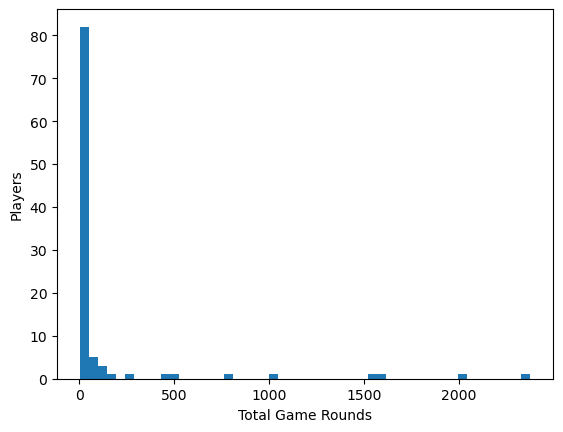

In [44]:
import matplotlib.pyplot as plt

# Counting the number of players for each number of gamerounds 
viz = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of random 100 players
viz_samp = viz.sample(n=100, random_state=2023)
viz_samp.plot(kind='hist', bins=50)
plt.xlabel("Total Game Rounds")
plt.ylabel("Players")
plt.show()

<p>In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!</p>

## 4. A/B testing for 1-day retention
<p>What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is <em>1-day retention</em>: The percentage of players that comes back and plays the game <em>one day</em> after they have installed it.  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>
<p>As a first step, let's look at what 1-day retention is overall.</p>

In [13]:
# The % of users that came back the day after they installed
df['retention_1'].sum() / df['retention_1'].count()

0.4452095044850259

### 4.1 Calculate 1-day retention by AB-group
<p><img src="https://assets.datacamp.com/production/project_184/img/belle_cookie.png" style="width:200px; float:right"> </p>
<p>Based on the data, it can be observed that slightly less than half of the players return to the game one day after installing it. With this initial benchmark established, our next step is to examine and compare the 1-day retention rates between the two AB-groups.</p>

In [14]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.448188
gate_40    0.442283
dtype: float64

<p>From the result above, there was a marginal decline in 1-day retention (44.2%) observed when the gate was relocated to level 40, in comparison to the control group where the gate was positioned at level 30 (44.8%). Although this change may seem insignificant, it is worth noting that even slight alterations in retention rates can yield substantial consequences. However, despite our confidence in the observed disparity within the data, the question remains: to what extent can we be certain that a gate placed at level 40 will exhibit poorer performance in the future?</p>

### 4.2 Examine the uncertainty with Bootstrapping
<p>To obtain the certainty of these retention numbers, bootstrapping will be applied: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.</p>

<Axes: ylabel='Density'>

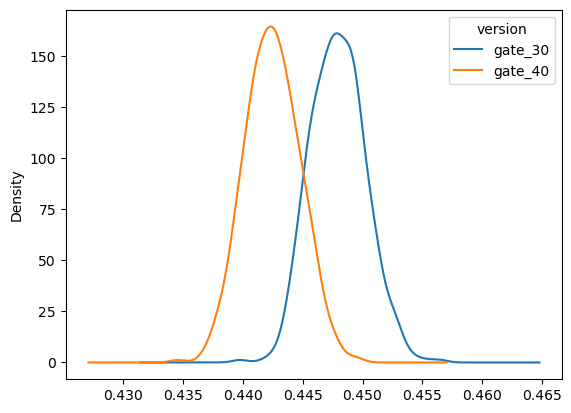

In [15]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='kde')

<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small.</p>

### 4.3 Zoom in the difference

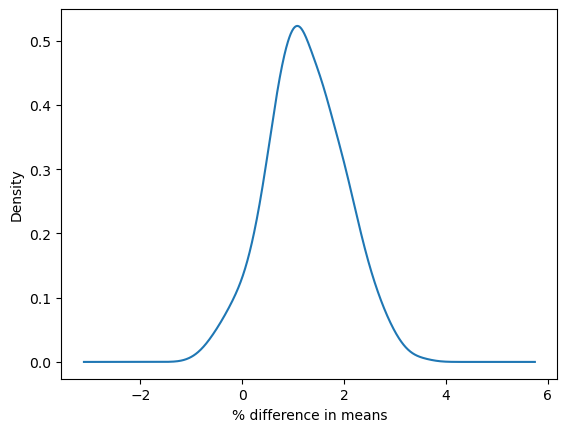

In [18]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
boot_1d['diff'].plot(kind = 'kde')
plt.xlabel("% difference in means")
plt.show()

From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. To look deeper, we can calculate the probability that the difference is above 0%.

In [35]:
# Calculating the probability that 1-day retention 
# is greater when the gate is at level 30.
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d)

# Pretty printing the probability
'{:.1%}'.format(prob)

'94.8%'

The bootstrap analysis indicates that there is a high probability that 1-day retention is better when the gate is at level 30.

Since players have only been engaged in the game for a single day, it is probable that the majority of them have not yet attained level 30. In other words, even if the gate is introduced at level 30, a considerable number of players would not have been impacted by it.

## 5. A/B testing for 7-day retention
<p>Considering the circumstances, it is reasonable to expect that a larger number of players would have achieved level 40 after a week of gameplay. Hence, it is worthwhile to examine the 7-day retention rate as well. In other words, we need to determine the percentage of individuals who installed the game and were still actively engaged in playing it one week later.</p>

### 5.1 Calculate 7-day retention by AB-group

In [32]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.190201
gate_40    0.182000
dtype: float64

<p>Similar to 1-day retention, we observe that 7-day retention is slightly lower (18.2%) when the gate is set at level 40 compared to when it is set at level 30 (19.0%). This disparity is greater than what we observed for 1-day retention, likely due to a larger number of players reaching the initial gate within that time frame. Additionally, it is worth noting that the overall 7-day retention is lower than the overall 1-day retention, indicating that fewer individuals continue playing the game one week after installation compared to just one day after installation.</p>

### 5.2 Examine the uncertainty with Bootstrapping

<Axes: ylabel='Density'>

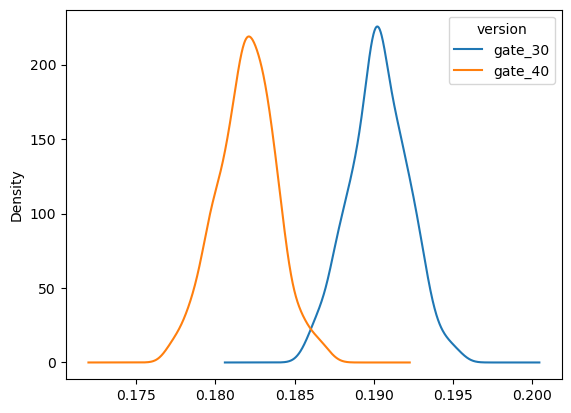

In [45]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# A Kernel Density Estimate plot of the bootstrap distributions
boot_7d.plot(kind='kde')

<p>Based on the figure provided, it is evident that there is a noticeable difference in the 7-day retention compared to the previous result (1-day retention).</p>

### 5.3 Zoom in the difference

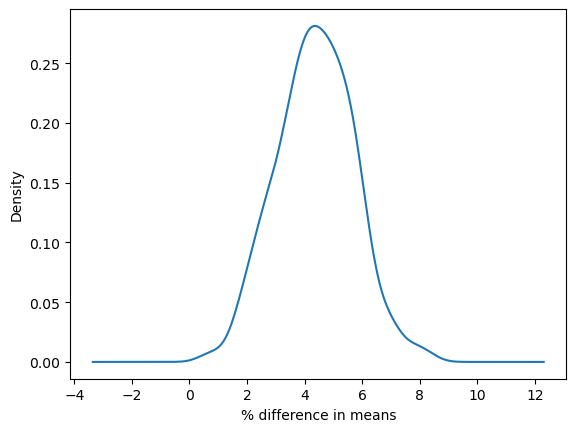

In [46]:
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_30'] * 100

# Ploting the bootstrap % difference
boot_7d['diff'].plot(kind = 'kde')
plt.xlabel("% difference in means")
plt.show()

In [36]:
# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

# Pretty printing the probability
'{:.1%}'.format(prob)

'100.0%'

Based on the bootstrap analysis, we have substantial evidence indicating that having the gate at level 30 results in higher 7-day retention compared to having it at level 40. Additionally, the probability also supports the same conclusion, suggesting that 7-day retention is more likely to be greater when the gate is set at level 30.

## 11.  The conclusion
<p>To maintain high player retention, it is recommended not to relocate the gate from level 30 to level 40. Although there is a minor difference in the player retention between two versions, the probability of retention still demonstrate a greater performance when the gate is located at level 30. </p>
<p>To explain why retention is higher when the gate is positioned earlier, the concept of hedonic adaptation offers a possible explanation for this phenomenon. In simple terms, hedonic adaptation refers to the tendency of individuals to experience diminishing enjoyment from a pleasurable activity over time, especially when it is engaged in continuously. By introducing gates in the game that prompt players to take breaks, their overall enjoyment of the game is extended. However, when the gate is shifted to level 40, fewer players manage to reach that milestone, increasing the likelihood of them quitting the game due to growing boredom. </p>